<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [312]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from keras.preprocessing.sequence import TimeseriesGenerator

In [313]:
ticker = "TSLA"
look_back = 5 #  number of past days we want to use to predict 1 day in the future.
max_data_size = 730 # ~2 years
split_percent = 0.90 # use 90% of the data  for train
print_level = 'DEBUG'
nr_of_features = 2
np.random.seed(42)

In [314]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=3F4URDEKOPLFH25T'
print(url)
stock_api_response = pd.read_json(url)
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);

data = []
lstm_data = []
split_coefficient = 1

for key, value in stock_api_data.items():
  date = key
  open = float(value.get('1. open'))
  high = float(value.get('2. high'))
  low = float(value.get('3. low'))
  close = float(value.get('4. close'))
  adjusted_close = float(value.get('5. adjusted close'))
  volume = int(value.get('6. volume'))
  divident = float(value.get('7. dividend amount'))

  if float(value.get('8. split coefficient')) > 1:
    split_coefficient = float(value.get('8. split coefficient'))
    
  open = open / split_coefficient
  high = high /split_coefficient
  close = close / split_coefficient
  low = low / split_coefficient
  
  # 3 features
  lstm_data.append([
    close#,
    #high,
    #low
  ])

  data.append([
      date,
      close,
      volume,
      high,
      low,
      open,
      divident
      ])

last_data =  str(data[0][0])

if max_data_size < len(data):
  data = np.flip(data[:max_data_size],axis=0)
  lstm_data = np.flip(lstm_data[:max_data_size],axis=0)
else:
  data = np.flip(data,axis=0)
  lstm_data = np.flip(lstm_data,axis=0)

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=TSLA&outputsize=full&apikey=3F4URDEKOPLFH25T


In [315]:
# Normalised values [0,max_price] as integer
values = data[:,2].astype(int)
max_price = np.amax(lstm_data)

values_scaled = (max_price*(values - np.min(values))/np.ptp(values)).astype(int)
lstm_data = np.append(lstm_data, np.expand_dims(values_scaled, axis=1), axis=1)

if print_level == 'DEBUG':
  print('max_price:',max_price)
  print('values:',values[:5])
  print('values_scaled',values_scaled[:5])
  print('lstm_data:',lstm_data[:5])

max_price: 1077.04
values: [ 7842508 11511200  6613500  6308800  5027000]
values_scaled [26 44 20 18 12]
lstm_data: [[ 72.61  26.00]
 [ 71.59  44.00]
 [ 73.03  20.00]
 [ 73.35  18.00]
 [ 73.32  12.00]]


In [316]:
if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('data ===>', 'size:',len(data), 'max_data_size:', max_data_size, 'shape:', data.shape)
  print(data[:look_back])
  print('lstm_data ===>', 'size:',len(lstm_data), 'max_data_size:', max_data_size, 'shape:', lstm_data.shape)
  print(lstm_data[:look_back])

data ===> size: 730 max_data_size: 730 shape: (730, 7)
[['2018-12-06' '72.612' '7842508' '73.476' '70.152' '71.202' '0.0']
 ['2018-12-07' '71.59400000000001' '11511200' '75.898' '71.53' '73.8'
  '0.0']
 ['2018-12-10' '73.03' '6613500' '73.196' '70.624' '72.0' '0.0']
 ['2018-12-11' '73.352' '6308800' '74.434' '72.046' '73.982' '0.0']
 ['2018-12-12' '73.32000000000001' '5027000' '74.382' '73.03200000000001'
  '73.884' '0.0']]
lstm_data ===> size: 730 max_data_size: 730 shape: (730, 2)
[[ 72.61  26.00]
 [ 71.59  44.00]
 [ 73.03  20.00]
 [ 73.35  18.00]
 [ 73.32  12.00]]


In [317]:
df = pd.DataFrame(data,columns=['Date','Close','Volume','High','Low','Open','Divident'])

df['50MA'] = df['Close'].rolling(50).mean()
df['100MA'] = df['Close'].rolling(100).mean()
df['200MA'] = df['Close'].rolling(200).mean()

split = int(split_percent*len(data))
if len(data) - split < look_back:
  split = look_back
split
#df.head()

df_train = df.iloc[:split]
df_test = df.iloc[split:]

lstm_train_data = lstm_data[:split]
lstm_test_data = lstm_data[split:]

In [318]:
if print_level == 'DEBUG':
  print('df_test ===>', 'size:',len(df_test),'shape:', df_test.shape)
  print(df_test.head())

  print('df_train ===>', 'size:',len(df_train),'shape:', df_train.shape)
  print(df_train.head())

  print('lstm_test_data ===>', 'size:',len(lstm_test_data), 'shape:', lstm_test_data.shape)
  print(lstm_test_data[:2*(look_back + 1)])

  print('lstm_train_data ===>', 'size:',len(lstm_train_data), 'shape:', lstm_train_data.shape)
  print(lstm_train_data[:2*(look_back + 1)])

df_test ===> size: 73 shape: (73, 10)
           Date   Close    Volume  ...      50MA     100MA      200MA
657  2021-07-19  646.22  21297090  ...  627.0756  654.1292  638.28975
658  2021-07-20   660.5  15487127  ...  626.8382  653.9120  639.35145
659  2021-07-21  655.29  13953338  ...  627.3632  653.7099  640.55245
660  2021-07-22  649.26  15105727  ...  628.0044  653.0182  641.67035
661  2021-07-23  643.38  14604944  ...  629.0742  652.5876  642.81735

[5 rows x 10 columns]
df_train ===> size: 657 shape: (657, 10)
         Date              Close    Volume    High  ... Divident 50MA 100MA  200MA
0  2018-12-06             72.612   7842508  73.476  ...      0.0  NaN   NaN    NaN
1  2018-12-07  71.59400000000001  11511200  75.898  ...      0.0  NaN   NaN    NaN
2  2018-12-10              73.03   6613500  73.196  ...      0.0  NaN   NaN    NaN
3  2018-12-11             73.352   6308800  74.434  ...      0.0  NaN   NaN    NaN
4  2018-12-12  73.32000000000001   5027000  74.382  ...      0.

In [319]:
np.set_printoptions(formatter={'float': '{: 0.12f}'.format})

mean_data = np.mean(lstm_data)
max_data = np.amax(lstm_data)

#print('mean:', mean_data, 'max:', max_data, 'min:',0)
scaler_data = [[mean_data], [max_data*1.5], [0]]

scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = scaler.fit(lstm_data)
scaler = scaler.fit(scaler_data)

lstm_train_data_scaled = scaler.transform(lstm_train_data)
if print_level == 'DEBUG':
  print(lstm_train_data_scaled[:look_back+1])

lstm_test_data_scaled = scaler.transform(lstm_test_data)
if print_level == 'DEBUG':
  print(lstm_test_data_scaled[:look_back+1])

[[ 0.044945405927  0.016093490802]
 [ 0.044315283864  0.027235138280]
 [ 0.045204139741  0.012379608309]
 [ 0.045403451435  0.011141647478]
 [ 0.045383644062  0.007427764986]
 [ 0.046645126148  0.014855529971]]
[[ 0.399997524078  0.056946198222]
 [ 0.408836564411  0.038995766174]
 [ 0.405611676447  0.034662903266]
 [ 0.401879224541  0.037757805343]
 [ 0.398239619698  0.036519844512]
 [ 0.407053900815  0.069325806531]]


In [320]:
train_generator = TimeseriesGenerator(lstm_train_data_scaled, lstm_train_data_scaled, length=look_back)

if print_level == 'TRACE':
  print('Samples: %d' % len(train_generator))
  # print each sample
  for i in range(2):
    x, y = train_generator[i]
    print('%s => %s' % (x, y))

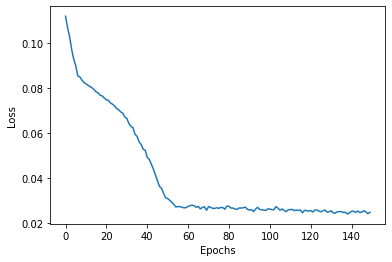

In [321]:
model = Sequential()
model.add(LSTM(units=50, activation='tanh', input_shape=(look_back, nr_of_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(nr_of_features))

model.compile(
    loss=MAE,
    optimizer=Adam(learning_rate=0.0001),
    metrics=["mae"]
)
  
#model.summary()

modelo = model.fit(train_generator, epochs=150, verbose=0)
if print_level == 'DEBUG':
  plt.plot(modelo.history['loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

In [322]:
test_generator = TimeseriesGenerator(lstm_test_data_scaled, lstm_test_data_scaled, length=look_back, batch_size=1)

print('Samples: %d' % len(test_generator))
# print each sample
if print_level == 'TRACE':
  for i in range(2):
    x, y = test_generator[i]
    print('%s => %s' % (x, y))

Samples: 68


In [323]:
#Make prediction
prediction_scaled = model.predict(test_generator)

if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.12f}'.format})
  print(prediction_scaled[:5])

prediction = scaler.inverse_transform(prediction_scaled)
pred_prices = prediction[:,0]

if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('prediction shape:',prediction.shape)

  for x in range(look_back + 1):
    print('pred:',prediction[x], 'test:', lstm_test_data[x])


[[ 0.387325376272  0.073498323560]
 [ 0.388281673193  0.073538333178]
 [ 0.385717630386  0.073245741427]
 [ 0.385040730238  0.073243595660]
 [ 0.386996120214  0.073595806956]]
prediction shape: (68, 2)
pred: [ 625.75  118.74] test: [ 646.22  92.00]
pred: [ 627.29  118.81] test: [ 660.50  63.00]
pred: [ 623.15  118.33] test: [ 655.29  56.00]
pred: [ 622.06  118.33] test: [ 649.26  61.00]
pred: [ 625.22  118.90] test: [ 643.38  59.00]
pred: [ 636.18  120.49] test: [ 657.62  112.00]


In [324]:
def predict(num_prediction, model):
    prediction_list = lstm_test_data_scaled[-look_back:]
    #print(prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, nr_of_features))
        out = model.predict(x)
        #print(x,out) 
        prediction_list = np.append(prediction_list, out, axis=0)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(last_date,num_prediction):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq=us_bd).tolist()
    return prediction_dates

num_prediction = look_back * 2
forecast_scaled = predict(num_prediction, model)
#print(forecast_scaled)
forecast_dates = predict_dates(df['Date'].values[-1],num_prediction)

forecast = scaler.inverse_transform(forecast_scaled.reshape((-1,1)))
forecast_prices = forecast[0::2].reshape((-1))
#forecast_dates,forecast
forecast_prices

array([ 1077.04,  1002.71,  1080.94,  1078.19,  1080.82,  1088.39,
        1079.55,  1121.94,  1122.88,  1128.63,  1137.82])

In [325]:
trace1 = go.Candlestick(
    x = df_train['Date'],
    open = df_train['Open'],
    high = df_train['High'],
    low = df_train['Low'],
    close = df_train['Close'],
    name = 'Train'
)

trace2 = go.Candlestick(
    x = df_test['Date'],
    open = df_test['Open'],
    high = df_test['High'],
    low = df_test['Low'],
    close = df_test['Close'],
    increasing={'line': {'color': 'lightblue'}},
    decreasing={'line': {'color': 'purple'}},    
    name ='Test'
)

trace3 = go.Scatter(
    x = df_test['Date'],
    y = pred_prices,
    name ='Test'
)

trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast_prices,
    name ='Forecast'
)

trace5 = go.Scatter(
    x = df['Date'],
    y = df['50MA'],
    mode='lines',
    name ='50MA'
)

trace6 = go.Scatter(
    x = df['Date'],
    y = df['100MA'],
    mode='lines',
    name ='100MA'
)

trace7 = go.Scatter(
    x = df['Date'],
    y = df['200MA'],
    mode='lines',
    name ='200MA'
)

#'Date','Close','Volume','High','Low','Open','Divident'
open_price =  str(data[-1][5])
low_price =  str(data[-1][3])
high_price =  str(data[-1][4])
close_price =  str(data[-1][1])

layout = go.Layout(
    title = ticker + ' Date:' + last_data + ' Open:' + open_price + ' High:' + high_price + ' Low:' + low_price + ' Close:' + close_price,
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "Close Price ($)"},
    height = 450
)

fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7], layout=layout)

fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
fig.update_layout(xaxis_rangeslider_visible=False)
config = dict({'scrollZoom': True})
fig.show(config=config)

fig1 = px.bar(
    x=df['Date'], 
    y=df['Volume'], 
    height=250, 
    labels={"x": "Dates","y": "Volume"},
    title=ticker)
fig1.show()